In [1]:
import os
import json
import sys
import pandas as pd
import torch

PROJECT_ROOT = "/media/ttoxopeus/basic_UNet"

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
    print(f"✅ Added project root to sys.path:\n   {PROJECT_ROOT}")
else:
    print(f"ℹ️ Project root already in sys.path:\n   {PROJECT_ROOT}")


from src.training.eval import evaluate
from src.models.unet import UNet
from src.pruning.model_inspect import model_to_dataframe_with_l1, get_pruning_masks_blockwise, compute_actual_prune_ratios, compute_l1_norms, compute_l1_stats
from src.pruning.rebuild import rebuild_pruned_unet, find_prev_conv_name

✅ Added project root to sys.path:
   /media/ttoxopeus/basic_UNet


/media/ttoxopeus/miniconda3/envs/nnunet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # Create baseline model
# model = UNet(in_ch=1, out_ch=4, enc_features=[64, 128, 256, 512])
# df = model_to_dataframe_with_l1(model, remove_nan_layers=True)
# pd.set_option('display.max_rows', None)
# display(df)

# 1️⃣ Create model
model = UNet(in_ch=1, out_ch=4, enc_features=[64, 128, 256, 512, 512])
state = torch.load("/media/ttoxopeus/basic_UNet/results/UNet_ACDC/exp41/baseline/training/final_model.pth", map_location="cpu")
model.load_state_dict(state)
model.eval()

# Path to your metrics file
metrics_path = "/media/ttoxopeus/basic_UNet/results/UNet_ACDC/exp41/baseline/evaluation/eval_metrics.json"

# Load JSON
with open(metrics_path, "r") as f:
    metrics = json.load(f)

# Extract values
mean_dice_fg = metrics["mean_dice_fg"]
mean_iou_fg = metrics["mean_iou_fg"]
per_class = metrics["per_class"]

# Print formatted output
print("✅ Evaluation on baseline model!")
print(f"📊 Mean Dice: {mean_dice_fg:.4f}")
print(f"📊 Mean IoU:  {mean_iou_fg:.4f}")
print("───────────────────────────────")

for class_name, vals in per_class.items():
    print(f"{class_name:12s}  Dice={vals['dice_mean']:.4f}  IoU={vals['iou_mean']:.4f}")

print("───────────────────────────────")

✅ Evaluation on baseline model!
📊 Mean Dice: 0.8163
📊 Mean IoU:  0.7528
───────────────────────────────
Background    Dice=0.9974  IoU=0.9949
RV            Dice=0.7623  IoU=0.7062
Myocardium    Dice=0.8062  IoU=0.7186
LV            Dice=0.8805  IoU=0.8337
───────────────────────────────


In [3]:
# 2️⃣ Compute per-filter L1 norms
norms = compute_l1_norms(model)

# 3️⃣ Compute L1 statistics from norms
l1_stats = compute_l1_stats(norms)

# 4️⃣ (Optional) define block ratios for later reference
#block_ratios = {"encoders.0": 0.2, "encoders.1": 0.3, "bottleneck": 0.4}

# 5️⃣ Build DataFrame with stats
df = model_to_dataframe_with_l1(
    model,
    l1_stats=l1_stats,
    remove_nan_layers=True
)

# 6️⃣ Display full DataFrame
pd.set_option("display.max_rows", None)
display(df)


,Layer,Type,Shape,In Ch,Out Ch,Num Params,Mean L1,Min L1,Max L1,L1 Std,Block Ratio,Post-Prune Ratio
0,encoders.0.net.0,Conv2d,"(64, 1, 3, 3)",1,64,576,1.551331,0.941511,2.025421,0.252934,None,None
1,encoders.0.net.3,Conv2d,"(64, 64, 3, 3)",64,64,36864,20.288008,14.836420,26.348740,2.820510,None,None
2,encoders.1.net.0,Conv2d,"(128, 64, 3, 3)",64,128,73728,20.560497,13.653543,29.073994,4.398217,None,None
3,encoders.1.net.3,Conv2d,"(128, 128, 3, 3)",128,128,147456,32.678024,21.367718,49.799278,6.812839,None,None
4,encoders.2.net.0,Conv2d,"(256, 128, 3, 3)",128,256,294912,34.095963,20.778049,52.540321,6.267731,None,None
5,encoders.2.net.3,Conv2d,"(256, 256, 3, 3)",256,256,589824,64.204262,35.262543,92.003357,13.836428,None,None
6,encoders.3.net.0,Conv2d,"(512, 256, 3, 3)",256,512,1179648,68.175964,34.533218,98.012207,13.933917,None,None
7,encoders.3.net.3,Conv2d,"(512, 512, 3, 3)",512,512,2359296,124.219528,53.179050,185.167419,25.643438,None,None
8,encoders.4.net.0,Conv2d,"(512, 512, 3, 3)",512,512,2359296,157.922775,100.266998,218.526779,16.962074,None,None
9,encoders.4.net.3,Conv2d,"(512, 512, 3, 3)",512,512,2359296,157.622177,109.752975,203.895996,16.077797,None,None


In [18]:
block_ratios = {
    # --- Encoder DoubleConvs ---
    "encoders.0": 0.0,
    "encoders.1": 0.0,
    "encoders.2": 0.0,
    "encoders.3": 0.0,
    "encoders.4": 0.0,

    # --- Bottleneck ---
    "bottleneck": 0.0,

    # --- Decoder DoubleConvs only (skip ConvTranspose2d ones) ---
    "decoders.1": 0.0,
    "decoders.3": 0.0,
    "decoders.5": 0.0,
    "decoders.7": 0.1,
    "decoders.9": 0.2,
}


# Then get the pruning masks
masks = get_pruning_masks_blockwise(
    model=model,
    norms=norms,
    block_ratios=block_ratios,
    default_ratio=0.25
)

🔧 Generating pruning masks...

Block encoders.0      | ratio=0.00 → keeping all 64 filters.
Block encoders.0      | ratio=0.00 → keeping all 64 filters.
Block encoders.1      | ratio=0.00 → keeping all 128 filters.
Block encoders.1      | ratio=0.00 → keeping all 128 filters.
Block encoders.2      | ratio=0.00 → keeping all 256 filters.
Block encoders.2      | ratio=0.00 → keeping all 256 filters.
Block encoders.3      | ratio=0.00 → keeping all 512 filters.
Block encoders.3      | ratio=0.00 → keeping all 512 filters.
Block encoders.4      | ratio=0.00 → keeping all 512 filters.
Block encoders.4      | ratio=0.00 → keeping all 512 filters.
Block bottleneck      | ratio=0.00 → keeping all 1024 filters.
Block bottleneck      | ratio=0.00 → keeping all 1024 filters.
Block decoders.1      | ratio=0.00 → keeping all 512 filters.
Block decoders.1      | ratio=0.00 → keeping all 512 filters.
Block decoders.3      | ratio=0.00 → keeping all 512 filters.
Block decoders.3      | ratio=0.00 → ke

🔧 Rebuilding pruned UNet architecture...
✅ Built pruned UNet | enc: [64, 128, 256, 512, 512], dec: [512, 512, 256, 115, 51], bottleneck: 1024
✂️ Pruned copy → encoders.0.net.0.weight: (64, 1, 3, 3)
📥 Copied non-pruned layer → encoders.0.net.1.weight: (64,)
📥 Copied non-pruned layer → encoders.0.net.1.bias: (64,)
📥 Copied non-pruned layer → encoders.0.net.1.running_mean: (64,)
📥 Copied non-pruned layer → encoders.0.net.1.running_var: (64,)
📥 Copied non-pruned layer → encoders.0.net.1.num_batches_tracked: ()
✂️ Pruned copy → encoders.0.net.3.weight: (64, 64, 3, 3)
📥 Copied non-pruned layer → encoders.0.net.4.weight: (64,)
📥 Copied non-pruned layer → encoders.0.net.4.bias: (64,)
📥 Copied non-pruned layer → encoders.0.net.4.running_mean: (64,)
📥 Copied non-pruned layer → encoders.0.net.4.running_var: (64,)
📥 Copied non-pruned layer → encoders.0.net.4.num_batches_tracked: ()
✂️ Pruned copy → encoders.1.net.0.weight: (128, 64, 3, 3)
📥 Copied non-pruned layer → encoders.1.net.1.weight: (128,)

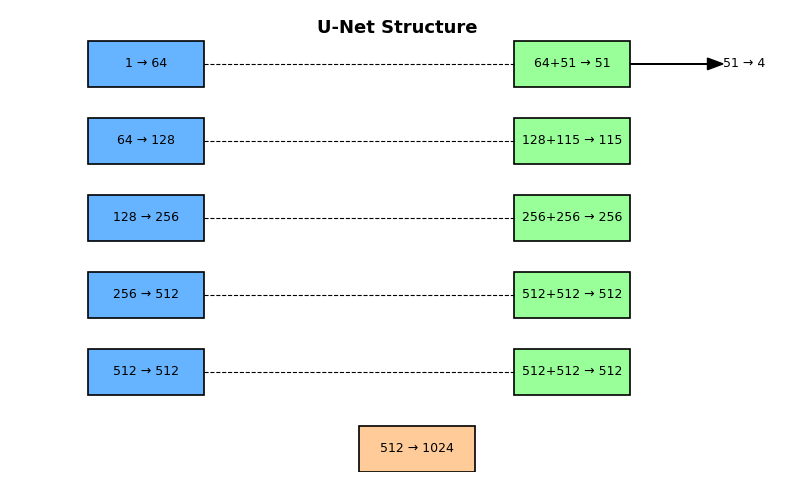

💾 Saved pruned model to /media/ttoxopeus/basic_UNet/results/UNet_ACDC/exp41/pruned/pruned_model.pth
✅ UNet successfully rebuilt.


In [19]:
from pathlib import Path
import torch.nn as nn


pruned_model = rebuild_pruned_unet(
    model,
    masks, 
    save_path=Path("/media/ttoxopeus/basic_UNet/results/UNet_ACDC/exp41/pruned/pruned_model.pth"))

post_ratios = compute_actual_prune_ratios(model, pruned_model)



# def summarize_model(model):
#     """
#     Prints a detailed summary useful for debugging structured pruning.
#     Includes:
#     - module name
#     - type
#     - weight/bias shapes
#     - in/out channels
#     - parameter count
#     - prunable (Conv2d or ConvTranspose2d)
#     """

#     print("\n📘 DETAILED MODEL SUMMARY\n" + "-"*100)

#     for name, module in model.named_modules():
#         if name == "":
#             continue

#         indent = "  " * name.count(".")
#         out = f"{indent}- {name:<40} ({module.__class__.__name__})"

#         # ---- parameter shapes ----
#         if hasattr(module, "weight") and module.weight is not None:
#             out += f"\n{indent}    weight: {tuple(module.weight.shape)}"

#         if hasattr(module, "bias") and module.bias is not None:
#             out += f"\n{indent}    bias:   {tuple(module.bias.shape)}"

#         # ---- in/out channels ----
#         if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
#             out += (f"\n{indent}    in_ch: {module.in_channels}, "
#                     f"out_ch: {module.out_channels}")

#         # ---- number of parameters ----
#         n_params = sum(p.numel() for p in module.parameters() if p is not None)
#         out += f"\n{indent}    params: {n_params}"

#         # ---- prunable? ----
#         prunable = isinstance(module, (nn.Conv2d, nn.ConvTranspose2d))
#         out += f"\n{indent}    prunable: {prunable}"

#         print(out + "\n")

#     print("-"*100)


# summarize_model(model)






In [20]:
# 2️⃣ Compute per-filter L1 norms
pruned_norms = compute_l1_norms(pruned_model)

# 3️⃣ Compute L1 statistics from norms
pruned_l1_stats = compute_l1_stats(pruned_norms)


df_pruned = model_to_dataframe_with_l1(
    pruned_model,
    l1_stats=pruned_l1_stats,
    remove_nan_layers=True, 
    block_ratios=block_ratios,
    post_prune_ratios=post_ratios
)

display(df_pruned)

,Layer,Type,Shape,In Ch,Out Ch,Num Params,Mean L1,Min L1,Max L1,L1 Std,Block Ratio,Post-Prune Ratio
0,encoders.0.net.0,Conv2d,"(64, 1, 3, 3)",1,64,576,1.551331,0.941511,2.025421,0.252934,0.0,0.0
1,encoders.0.net.3,Conv2d,"(64, 64, 3, 3)",64,64,36864,20.288008,14.836420,26.348740,2.820510,0.0,0.0
2,encoders.1.net.0,Conv2d,"(128, 64, 3, 3)",64,128,73728,20.560497,13.653543,29.073994,4.398217,0.0,0.0
3,encoders.1.net.3,Conv2d,"(128, 128, 3, 3)",128,128,147456,32.678024,21.367718,49.799278,6.812839,0.0,0.0
4,encoders.2.net.0,Conv2d,"(256, 128, 3, 3)",128,256,294912,34.095963,20.778049,52.540321,6.267731,0.0,0.0
5,encoders.2.net.3,Conv2d,"(256, 256, 3, 3)",256,256,589824,64.204262,35.262543,92.003357,13.836428,0.0,0.0
6,encoders.3.net.0,Conv2d,"(512, 256, 3, 3)",256,512,1179648,68.175964,34.533218,98.012207,13.933917,0.0,0.0
7,encoders.3.net.3,Conv2d,"(512, 512, 3, 3)",512,512,2359296,124.219528,53.179050,185.167419,25.643438,0.0,0.0
8,encoders.4.net.0,Conv2d,"(512, 512, 3, 3)",512,512,2359296,157.922775,100.266998,218.526779,16.962074,0.0,0.0
9,encoders.4.net.3,Conv2d,"(512, 512, 3, 3)",512,512,2359296,157.622177,109.752975,203.895996,16.077797,0.0,0.0


In [21]:
def interleave_compare(df_base: pd.DataFrame, df_pruned: pd.DataFrame) -> pd.DataFrame:
    """
    Merge two layer-summary dataframes on 'Layer' and interleave
    baseline and pruned columns for easy comparison.

    Returns:
        pd.DataFrame: merged dataframe with interleaved _base and _pruned columns
    """

    # Merge on layer name
    dfm = df_base.merge(df_pruned, on="Layer", how="outer", suffixes=("_base", "_pruned"))

    # Identify columns
    base_cols   = [c for c in dfm.columns if c.endswith("_base")]
    pruned_cols = [c for c in dfm.columns if c.endswith("_pruned")]

    # Build interleaved order
    interleaved = ["Layer"]

    for bc in base_cols:
        stem = bc[:-5]          # remove "_base"
        pc = stem + "_pruned"   # corresponding pruned col
        interleaved.append(bc)
        if pc in dfm.columns:
            interleaved.append(pc)

    # Add any remaining columns
    for c in dfm.columns:
        if c not in interleaved:
            interleaved.append(c)

    return dfm[interleaved]


df_compare = interleave_compare(df, df_pruned)


# display(df_compare.iloc[:, :-4])

display(pd.concat([
    df_compare.iloc[:, :2],     # first 2 columns
    df_compare.iloc[:, 9:-4]    # your selected range
], axis=1))


,Layer,Type_base,Num Params_base,Num Params_pruned,Mean L1_base,Mean L1_pruned,Min L1_base,Min L1_pruned,Max L1_base,Max L1_pruned,L1 Std_base,L1 Std_pruned
0,bottleneck.net.0,Conv2d,4718592,4718592,144.267090,144.267090,101.880554,101.880554,178.879700,178.879700,14.665365,14.665365
1,bottleneck.net.3,Conv2d,9437184,9437184,223.883591,223.883591,106.554153,106.554153,386.406921,386.406921,57.562244,57.562244
2,decoders.0,ConvTranspose2d,2097664,2097664,44.556839,44.556839,25.305153,25.305153,105.051765,105.051765,13.880632,13.880632
3,decoders.1.net.0,Conv2d,4718592,4718592,238.616776,238.616776,123.579475,123.579475,373.426453,373.426453,47.908344,47.908344
4,decoders.1.net.3,Conv2d,2359296,2359296,124.202682,124.202682,67.089867,67.089867,196.433594,196.433594,23.418732,23.418732
5,decoders.2,ConvTranspose2d,1049088,1049088,35.004063,35.004063,25.395571,25.395571,89.083595,89.083595,8.937863,8.937863
6,decoders.3.net.0,Conv2d,4718592,4718592,195.009918,195.009918,114.482597,114.482597,330.603760,330.603760,47.722992,47.722992
7,decoders.3.net.3,Conv2d,2359296,2359296,121.828407,121.828407,70.042984,70.042984,208.503860,208.503860,24.941704,24.941704
8,decoders.4,ConvTranspose2d,524544,524544,22.916687,22.916687,16.601276,16.601276,49.586506,49.586506,5.298937,5.298937
9,decoders.5.net.0,Conv2d,1179648,1179648,111.650238,111.650238,72.193024,72.193024,171.599548,171.599548,22.337379,22.337379


In [22]:
import torch

def compare_models(model, pruned_model, atol=1e-6, verbose=True):
    """
    Compare two PyTorch models layer-by-layer.

    Shows:
    - shape differences
    - weight differences (allclose)
    - mean/std differences
    - summary counts

    Args:
        model: baseline model
        pruned_model: pruned or rebuilt model
        atol: absolute tolerance for allclose
        verbose: whether to print per-layer info

    Returns:
        dict with summary stats
    """

    diffs = []
    same = []
    shape_diffs = []
    stats = []

    for (name1, p1), (name2, p2) in zip(model.named_parameters(), pruned_model.named_parameters()):

        if name1 != name2:
            raise ValueError(f"Layer order/name mismatch: {name1} != {name2}")

        # Shape mismatch
        if p1.shape != p2.shape:
            shape_diffs.append((name1, p1.shape, p2.shape))
            if verbose:
                print(f"❌ SHAPE DIFF: {name1}: {p1.shape} vs {p2.shape}")
            continue

        # Weight difference
        equal = torch.allclose(p1, p2, atol=atol)

        if equal:
            same.append(name1)
            if verbose:
                print(f"✔ SAME: {name1}")
        else:
            diffs.append(name1)
            if verbose:
                print(f"❌ DIFF: {name1}")

        # Mean/std comparison
        stats.append({
            "Layer": name1,
            "Mean_base": p1.mean().item(),
            "Mean_pruned": p2.mean().item(),
            "Std_base": p1.std().item(),
            "Std_pruned": p2.std().item(),
        })

    summary = {
        "num_layers": len(same) + len(diffs) + len(shape_diffs),
        "same_layers": len(same),
        "diff_layers": len(diffs),
        "shape_diffs": len(shape_diffs),
        "same_list": same,
        "diff_list": diffs,
        "shape_diff_list": shape_diffs,
        "stats": stats,
    }

    print("\n================ SUMMARY ================")
    print(f"Total layers:       {summary['num_layers']}")
    print(f"✔ Identical:        {summary['same_layers']}")
    print(f"❌ Weight diffs:     {summary['diff_layers']}")
    print(f"❌ Shape diffs:      {summary['shape_diffs']}")
    print("=========================================\n")

    return summary


summary = compare_models(model, pruned_model)


✔ SAME: encoders.0.net.0.weight
✔ SAME: encoders.0.net.1.weight
✔ SAME: encoders.0.net.1.bias
✔ SAME: encoders.0.net.3.weight
✔ SAME: encoders.0.net.4.weight
✔ SAME: encoders.0.net.4.bias
✔ SAME: encoders.1.net.0.weight
✔ SAME: encoders.1.net.1.weight
✔ SAME: encoders.1.net.1.bias
✔ SAME: encoders.1.net.3.weight
✔ SAME: encoders.1.net.4.weight
✔ SAME: encoders.1.net.4.bias
✔ SAME: encoders.2.net.0.weight
✔ SAME: encoders.2.net.1.weight
✔ SAME: encoders.2.net.1.bias
✔ SAME: encoders.2.net.3.weight
✔ SAME: encoders.2.net.4.weight
✔ SAME: encoders.2.net.4.bias
✔ SAME: encoders.3.net.0.weight
✔ SAME: encoders.3.net.1.weight
✔ SAME: encoders.3.net.1.bias
✔ SAME: encoders.3.net.3.weight
✔ SAME: encoders.3.net.4.weight
✔ SAME: encoders.3.net.4.bias
✔ SAME: encoders.4.net.0.weight
✔ SAME: encoders.4.net.1.weight
✔ SAME: encoders.4.net.1.bias
✔ SAME: encoders.4.net.3.weight
✔ SAME: encoders.4.net.4.weight
✔ SAME: encoders.4.net.4.bias
✔ SAME: bottleneck.net.0.weight
✔ SAME: bottleneck.net.1.wei

In [23]:
import torch

def compare_models_pruned(model, pruned_model, masks, atol=1e-6, verbose=True):
    """
    Compare two models, compatible with pruned models.

    If shapes differ, compares only the overlapping pruned slices:
        - For Conv2d: out_channels + in_channels sliced by masks
        - For BN: only sliced output channels
        - For ConvTranspose2d: input channels sliced

    Args:
        model: original UNet
        pruned_model: pruned UNet
        masks: dict of pruning masks per module (True=keep)
        atol: tolerance for allclose
        verbose: print layer-by-layer details
    """

    same = []
    diffs = []
    shape_diffs = []

    for (name1, p1), (name2, p2) in zip(model.named_parameters(), pruned_model.named_parameters()):

        if name1 != name2:
            raise ValueError(f"Layer mismatch: {name1} != {name2}")

        module_name = name1.rsplit(".", 1)[0]

        # Case 1: shapes identical → direct comparison
        if p1.shape == p2.shape:
            equal = torch.allclose(p1, p2, atol=atol)
            if equal:
                same.append(name1)
                if verbose: print(f"✔ SAME: {name1}")
            else:
                diffs.append(name1)
                if verbose: print(f"❌ DIFF: {name1}")
            continue

        # Case 2: shapes differ → compare overlapping pruned slices
        mask_layer = find_mask_layer(module_name, masks)
        if mask_layer:
            mask = masks[mask_layer]

            # For Conv2d weight: [out, in, k, k]
            if p1.ndim == 4:
                parent = find_parent_for_compare(name1, masks)
                if parent in masks:
                    parent_mask = masks[parent]
                    slice1 = p1[mask][:, parent_mask]
                    slice2 = p2
                else:
                    slice1 = p1[mask]
                    slice2 = p2

            # For BN: weight, bias, running_mean, running_var
            elif p1.ndim == 1:
                slice1 = p1[mask]
                slice2 = p2

            else:
                slice1 = None

            if slice1 is not None and slice1.shape == slice2.shape:
                equal = torch.allclose(slice1, slice2, atol=atol)
                if equal:
                    same.append(name1)
                    if verbose: print(f"✔ SAME (pruned slice): {name1}")
                else:
                    diffs.append(name1)
                    if verbose: print(f"❌ DIFF (pruned slice): {name1}")
            else:
                shape_diffs.append((name1, slice1.shape if slice1 is not None else None, p2.shape))
                if verbose:
                    print(f"❌ SHAPE DIFF (slice mismatch): {name1}")
        else:
            # Non-pruned layer but shapes differ → warn
            shape_diffs.append((name1, p1.shape, p2.shape))
            if verbose:
                print(f"❌ SHAPE DIFF (non-pruned): {name1}")

    print("\n================ SUMMARY ================")
    print(f"✔ Identical (full or pruned slice): {len(same)}")
    print(f"❌ Weight diffs:                   {len(diffs)}")
    print(f"❌ Shape diffs:                    {len(shape_diffs)}")
    print("=========================================\n")

    return {
        "same": same,
        "diffs": diffs,
        "shape_diffs": shape_diffs
    }


def find_parent_for_compare(name, masks):
    parts = name.split(".")
    # try to detect “previous conv” inside DoubleConv
    if parts[-1].isdigit():
        idx = int(parts[-1])
        if idx > 0:
            parts[-1] = str(idx - 1)
            parent = ".".join(parts)
            if parent in masks:
                return parent
    return None

def find_mask_layer(module_name, masks):
    """
    Map parameter or BN layer to the correct Conv2d mask.
    Example:
        decoders.9.net.1.weight → decoders.9.net.0
        decoders.9.net.4.bias   → decoders.9.net.3
    """

    # 1. Direct hit (Conv2d layer)
    if module_name in masks:
        return module_name

    # 2. BN layer → previous Conv2d (idx - 1)
    parts = module_name.split(".")
    if parts[-1].isdigit():
        idx = int(parts[-1])
        if idx > 0:
            prev_name = ".".join(parts[:-1] + [str(idx - 1)])
            if prev_name in masks:
                return prev_name

    # 3. No associated mask
    return None



summary = compare_models_pruned(model, pruned_model, masks)

✔ SAME: encoders.0.net.0.weight
✔ SAME: encoders.0.net.1.weight
✔ SAME: encoders.0.net.1.bias
✔ SAME: encoders.0.net.3.weight
✔ SAME: encoders.0.net.4.weight
✔ SAME: encoders.0.net.4.bias
✔ SAME: encoders.1.net.0.weight
✔ SAME: encoders.1.net.1.weight
✔ SAME: encoders.1.net.1.bias
✔ SAME: encoders.1.net.3.weight
✔ SAME: encoders.1.net.4.weight
✔ SAME: encoders.1.net.4.bias
✔ SAME: encoders.2.net.0.weight
✔ SAME: encoders.2.net.1.weight
✔ SAME: encoders.2.net.1.bias
✔ SAME: encoders.2.net.3.weight
✔ SAME: encoders.2.net.4.weight
✔ SAME: encoders.2.net.4.bias
✔ SAME: encoders.3.net.0.weight
✔ SAME: encoders.3.net.1.weight
✔ SAME: encoders.3.net.1.bias
✔ SAME: encoders.3.net.3.weight
✔ SAME: encoders.3.net.4.weight
✔ SAME: encoders.3.net.4.bias
✔ SAME: encoders.4.net.0.weight
✔ SAME: encoders.4.net.1.weight
✔ SAME: encoders.4.net.1.bias
✔ SAME: encoders.4.net.3.weight
✔ SAME: encoders.4.net.4.weight
✔ SAME: encoders.4.net.4.bias
✔ SAME: bottleneck.net.0.weight
✔ SAME: bottleneck.net.1.wei

IndexError: The shape of the mask [256] at index 0 does not match the shape of the indexed tensor [128] at index 0